In [1]:
import torch
import torch.nn.functional as F
import numpy as np                 # import numpy
import matplotlib.pyplot as plt    # import matplotlib
from torch.utils.data import Dataset, DataLoader,random_split
import torch.optim as optim
from tqdm import tqdm
import h5py
import scipy
from scipy.signal import find_peaks
from IPython.display import Image
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
import optuna

import utils
import Model
import Simulate_Dataset

# Set a random seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
# dataset parameters
fs = 1000                     # sampling frequency in Hz
data_dur =  3*63                 # data duration in s
actpot_dur = 5                   # action potential length in ms
window_dur = 3                   # window dutation in s
C = 1                              # number of neurons
s = 40                              # number of appearance of each neuron in each window
x_mean = 2                         # code amplitude mean
x_std = 0.1                         # code amplitude std
noise_std = 0.1
snr = 20

K = int(actpot_dur * fs / 1000) # filter legnth
N = int(window_dur * fs)        # example duration
J = int(data_dur / window_dur)  # number of examples

# data parameters
data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
           "x_std": x_std, "SNR": snr, "device": device}

print("filter length:", K)
print("example duration:", N)
print("number of examples:", J)

filter length: 5
example duration: 3000
number of examples: 63


In [144]:
# fill in the gaps
net_hyp = {"T": 200,                 # number of encoder unfolding
           "L": 10,                  # 1/L is the step size in the encoder
           "C": 1,                 # number of filters
           "K": 18,                  # legnth of the filters
           "lam": 0.2,
           "device": device
           }

net = Model.CRsAE1D(net_hyp)

# training parameters
train_hyp = {"batch_size": 8, "num_epochs": 15, "lr": 1e-2, "shuffle": True}
# criterion
criterion = torch.nn.MSELoss()
# optimizer
optimizer = optim.Adam(net.parameters(), lr=train_hyp["lr"], eps=1e-3)

In [159]:
snr_list = [(10,0.15),(15,0.15),(20,0.1),(25,0.05),(30,0.05),(35,0.1),(40,0),(45,0),(50,0),(-10,0.9),(-5,0.5),(0,0.3),(5,0.25)]
snr_list = [(-10,0.9)]
x_const = None

In [160]:
for cur_snr, cur_lam in snr_list:
    net_hyp = {"T": 200,                 # number of encoder unfolding
            "L": 10,                  # 1/L is the step size in the encoder
            "C": 2,                 # number of filters
            "K": 18,                  # legnth of the filters
            "lam": cur_lam,
            "device": device
            }
    data_hyp ={"J": J, "N": N, "K": K, "C": C, "s": s, "x_mean": x_mean,
            "x_std": x_std, "SNR": cur_snr, "device": device}
    dataset = Simulate_Dataset.SimulatedDataset1D(data_hyp,x_const,one_kernel = True)
    train_loader = DataLoader(dataset, shuffle=train_hyp["shuffle"], batch_size=train_hyp["batch_size"])
    H_init = utils.initialize_filter(dataset.H.clone(),device)
    net = Model.CRsAE1D(net_hyp)

    # each loop is one pass over the whole dataset
    for epoch in tqdm(range(train_hyp["num_epochs"]), disable=True):
        loss_all = 0
        # each loop is a mini-batch
        for idx, (y,_,_,_) in tqdm(enumerate(train_loader), disable=False):
            # load data input the device
            y = y.to(device)
            # run the network in forward net(y) to get y_hat and x_hat
            y_hat, _= net(y)
            # compute loss using the created criterion
            loss = criterion(y, y_hat)
            loss_all += float(loss.item())
            # set the gradients in the optimizer to zero (optimizer.zero_grad())
            optimizer.zero_grad()
            # do backward on the loss
            loss.backward()
            # take a step with the optimizer
            optimizer.step()
            # normalize filters
            net.normalize()

    with torch.no_grad():
      y,x,_,_ = dataset[:]
      x_const = x
      x = torch.sum(x, dim=1, keepdim=True)
      y_hat, x_hat = net(y)
      #utils.vis_data_est(y[1,0], y_hat[1,0])
      x_hat = torch.sum(x_hat, dim=1, keepdim=True)
      y = y.squeeze(dim = 1)
      b = x[0,0] > 0
      x = x.squeeze(dim = 1)
      y_hat = y_hat.squeeze(dim = 1)
      x_hat = x_hat.squeeze(dim = 1)
      padding_begining = 7
      padding_end = 10
      # Perform the padding
      padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])
      modified_tensor = torch.zeros_like(padded_tensor).to(device)
      indices_of_ones = torch.nonzero(padded_tensor).squeeze()

      for index in indices_of_ones:
        modified_tensor[index-1:index+3] = 1

8it [00:01,  5.37it/s]
8it [00:01,  5.88it/s]
8it [00:01,  6.19it/s]
8it [00:01,  5.62it/s]
8it [00:01,  5.68it/s]
8it [00:01,  5.88it/s]
8it [00:01,  5.80it/s]
8it [00:01,  5.80it/s]
8it [00:01,  6.05it/s]
8it [00:01,  5.72it/s]
8it [00:01,  5.86it/s]
8it [00:01,  5.71it/s]
8it [00:01,  5.80it/s]
8it [00:01,  6.39it/s]
8it [00:01,  5.79it/s]
C:\Users\yonatan.kle\AppData\Local\Temp\ipykernel_12652\2445258252.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  padded_tensor = torch.cat([torch.zeros(padding_begining).to(device), torch.tensor(b),torch.zeros(padding_end).to(device)])


3013
3013


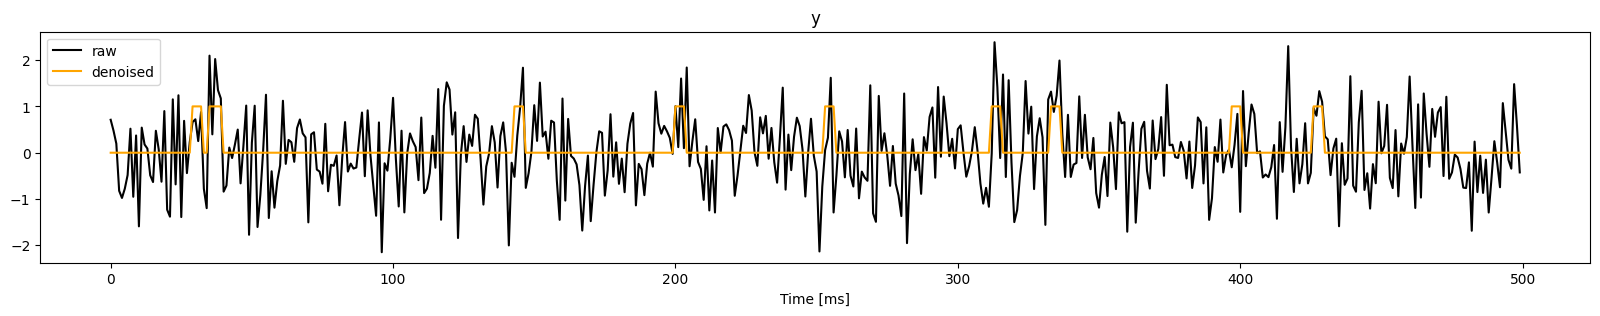

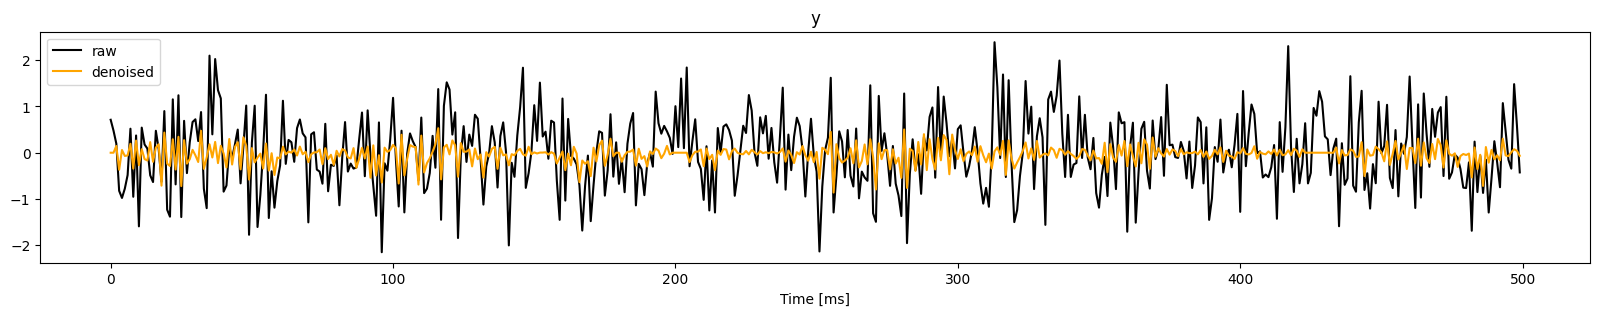

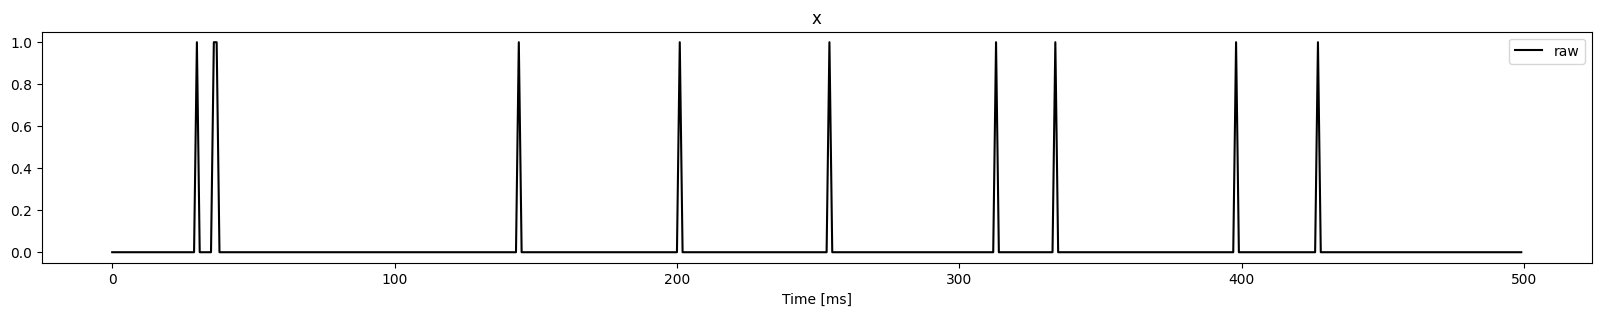

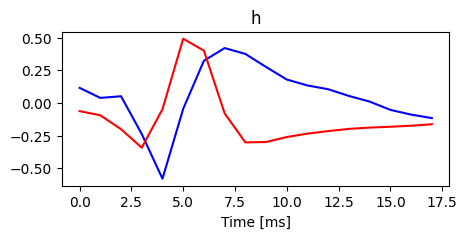

In [161]:
yi,xi,h,_ = dataset[0:3]
yi_hat, xi_hat = net(yi)

utils.vis_data_est(yi[0,0][0:500], modified_tensor[0:500])
utils.vis_data_est(yi[0,0][0:500], yi_hat[0,0][0:500])


print(len(padded_tensor))
print(len(yi[0,0]))
utils.vis_data(padded_tensor[0:500])
#utils.vis_data(b)
utils.vis_filters(h)

In [162]:
torch.save(net.state_dict(),f'pretrained_on_simulated_data\snr_{snr_list[0][0]}.pth')